In [144]:
import numpy as np
import pandas as pd
import xgboost
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [145]:
train = pd.read_csv('dataset-0510/train.csv')
test = pd.read_csv('dataset-0510/test.csv')

In [146]:
target = train['total_price']
train.drop('total_price', axis=1, inplace=True)

In [147]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

# 填空值
- 這次是把 training 跟 testing 先合併，然後根據相同 city 中的相同 town 來填 village_income_median 的空值
- 取的是 median

In [148]:
df['village_income_median'].fillna(value=df.groupby(['city','town'])
                                   ['village_income_median'].transform('median'), 
                                   inplace=True)
print("groupby 之後還是有缺值：",len(df[df['village_income_median'].isnull()]))
df['village_income_median'].fillna(df['village_income_median'].mode(),inplace=True)

groupby 之後還是有缺值： 34


In [149]:
df['txn_floor'].fillna(df['total_floor'] // 2, inplace=True)
df['txn_floor'] = df['txn_floor'].astype('int64')

# drop some feature

In [157]:
df.drop(['parking_area','parking_price'],axis=1,inplace=True)

# get dummy

In [130]:
def dummy_transform(df):
    categorical = []
    cat = ['total_floor','building_material',
       'city','building_type','txn_floor',
       'building_use','parking_way']
    categorical = cat + categorical
    numerical = [i for i in df.columns if i not in categorical]
    for col in categorical:
        df[col] = df[col].astype(str)
    df_dummy = pd.get_dummies(df[categorical])
    return pd.concat([df[numerical],df_dummy], axis=1) 

In [158]:
df = dummy_transform(df)

In [159]:
df.shape

(70000, 321)

# instinct work
- I drop some feature because those features never appear in testing data

In [160]:
df.drop(['building_material_5','txn_floor_28'], axis=1, inplace=True)

# split data and ready to train

In [161]:
train = df.head(60000)
test = df.tail(10000)

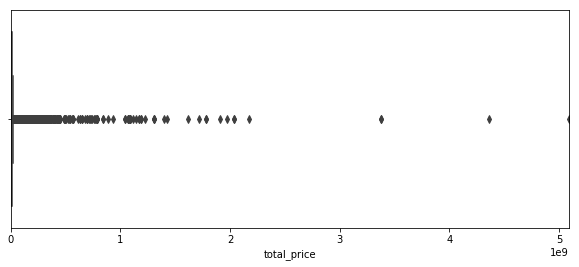

In [169]:
tmp = pd.concat([train,target],axis=1)
plt.figure(figsize=(10,4))
plt.xlim(tmp['total_price'].min(), tmp['total_price'].max())
sns.boxplot(x=tmp['total_price'])

In [172]:
np.percentile(tmp['total_price'], 97)

55609672.44422251

In [173]:
len(tmp[tmp['total_price'] < np.percentile(tmp['total_price'], 97)])

58197

In [137]:
y = np.log1p(target)
X = train.drop(['building_id'],axis=1)

In [138]:
X_valid = X[50000:]
y_valid = y[50000:]
X = X[:50000]
y = y[:50000]

In [140]:
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance

In [141]:
def validation(prediction, ground_true):
    ground_true = np.floor(np.expm1(ground_true))
    ground_true = ground_true.reset_index(drop=True)
    
    prediction = np.floor(np.expm1(prediction))
    
    score = 0
    for i in range(len(prediction)):
        pred = prediction[i]
        roof = ground_true[i] + ground_true[i] / 10
        floor = ground_true[i] - ground_true[i] / 10
        if (pred <= roof) and (pred >= floor):
            score += 1
    return score

In [142]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=5000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
    nthread=8,
    seed=41)

model.fit(
    X, 
    y, 
    eval_metric="rmse", 
    eval_set=[(X, y), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 80)


[0]	validation_0-rmse:13.5616	validation_1-rmse:13.5563
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 80 rounds.
[1]	validation_0-rmse:12.2099	validation_1-rmse:12.2057
[2]	validation_0-rmse:10.9921	validation_1-rmse:10.9892
[3]	validation_0-rmse:9.8959	validation_1-rmse:9.89406
[4]	validation_0-rmse:8.90942	validation_1-rmse:8.90789
[5]	validation_0-rmse:8.02173	validation_1-rmse:8.02103
[6]	validation_0-rmse:7.22316	validation_1-rmse:7.22296
[7]	validation_0-rmse:6.50438	validation_1-rmse:6.5049
[8]	validation_0-rmse:5.85737	validation_1-rmse:5.85879
[9]	validation_0-rmse:5.27536	validation_1-rmse:5.27712
[10]	validation_0-rmse:4.75171	validation_1-rmse:4.75377
[11]	validation_0-rmse:4.28047	validation_1-rmse:4.2828
[12]	validation_0-rmse:3.85669	validation_1-rmse:3.85918
[13]	validation_0-rmse:3.4753	validation_1-rmse:3.47824
[14]	validation_0-rmse:3.13248	validation_1-rmse:3.13547


[137]	validation_0-rmse:0.231206	validation_1-rmse:0.246837
[138]	validation_0-rmse:0.230878	validation_1-rmse:0.24666
[139]	validation_0-rmse:0.230477	validation_1-rmse:0.246309
[140]	validation_0-rmse:0.230245	validation_1-rmse:0.246065
[141]	validation_0-rmse:0.230041	validation_1-rmse:0.24596
[142]	validation_0-rmse:0.229801	validation_1-rmse:0.245743
[143]	validation_0-rmse:0.229702	validation_1-rmse:0.24569
[144]	validation_0-rmse:0.229518	validation_1-rmse:0.245573
[145]	validation_0-rmse:0.229323	validation_1-rmse:0.245438
[146]	validation_0-rmse:0.229136	validation_1-rmse:0.245367
[147]	validation_0-rmse:0.229045	validation_1-rmse:0.24527
[148]	validation_0-rmse:0.228887	validation_1-rmse:0.245137
[149]	validation_0-rmse:0.228754	validation_1-rmse:0.245084
[150]	validation_0-rmse:0.228363	validation_1-rmse:0.244783
[151]	validation_0-rmse:0.227915	validation_1-rmse:0.244491
[152]	validation_0-rmse:0.227737	validation_1-rmse:0.244404
[153]	validation_0-rmse:0.227503	validation_

[274]	validation_0-rmse:0.209568	validation_1-rmse:0.233911
[275]	validation_0-rmse:0.209527	validation_1-rmse:0.233886
[276]	validation_0-rmse:0.209501	validation_1-rmse:0.233887
[277]	validation_0-rmse:0.209319	validation_1-rmse:0.233802
[278]	validation_0-rmse:0.209278	validation_1-rmse:0.233761
[279]	validation_0-rmse:0.209195	validation_1-rmse:0.233687
[280]	validation_0-rmse:0.209169	validation_1-rmse:0.233676
[281]	validation_0-rmse:0.209121	validation_1-rmse:0.233689
[282]	validation_0-rmse:0.209023	validation_1-rmse:0.233647
[283]	validation_0-rmse:0.208928	validation_1-rmse:0.233589
[284]	validation_0-rmse:0.208891	validation_1-rmse:0.233571
[285]	validation_0-rmse:0.208831	validation_1-rmse:0.233557
[286]	validation_0-rmse:0.208785	validation_1-rmse:0.233552
[287]	validation_0-rmse:0.208599	validation_1-rmse:0.233453
[288]	validation_0-rmse:0.208507	validation_1-rmse:0.233425
[289]	validation_0-rmse:0.208474	validation_1-rmse:0.233417
[290]	validation_0-rmse:0.208373	validat

[411]	validation_0-rmse:0.197034	validation_1-rmse:0.228481
[412]	validation_0-rmse:0.196979	validation_1-rmse:0.228447
[413]	validation_0-rmse:0.196933	validation_1-rmse:0.228417
[414]	validation_0-rmse:0.196792	validation_1-rmse:0.228365
[415]	validation_0-rmse:0.196745	validation_1-rmse:0.228322
[416]	validation_0-rmse:0.196667	validation_1-rmse:0.228285
[417]	validation_0-rmse:0.196615	validation_1-rmse:0.228264
[418]	validation_0-rmse:0.196587	validation_1-rmse:0.22825
[419]	validation_0-rmse:0.19655	validation_1-rmse:0.228254
[420]	validation_0-rmse:0.19647	validation_1-rmse:0.228219
[421]	validation_0-rmse:0.196283	validation_1-rmse:0.228147
[422]	validation_0-rmse:0.196245	validation_1-rmse:0.228154
[423]	validation_0-rmse:0.196198	validation_1-rmse:0.228122
[424]	validation_0-rmse:0.196078	validation_1-rmse:0.228056
[425]	validation_0-rmse:0.196062	validation_1-rmse:0.228044
[426]	validation_0-rmse:0.196022	validation_1-rmse:0.228036
[427]	validation_0-rmse:0.195937	validation

[549]	validation_0-rmse:0.187908	validation_1-rmse:0.224591
[550]	validation_0-rmse:0.187843	validation_1-rmse:0.224571
[551]	validation_0-rmse:0.187727	validation_1-rmse:0.224561
[552]	validation_0-rmse:0.187688	validation_1-rmse:0.224565
[553]	validation_0-rmse:0.187605	validation_1-rmse:0.22452
[554]	validation_0-rmse:0.187563	validation_1-rmse:0.224501
[555]	validation_0-rmse:0.187461	validation_1-rmse:0.22449
[556]	validation_0-rmse:0.187393	validation_1-rmse:0.224475
[557]	validation_0-rmse:0.187337	validation_1-rmse:0.224481
[558]	validation_0-rmse:0.187297	validation_1-rmse:0.224458
[559]	validation_0-rmse:0.187237	validation_1-rmse:0.22439
[560]	validation_0-rmse:0.18715	validation_1-rmse:0.224362
[561]	validation_0-rmse:0.187035	validation_1-rmse:0.224364
[562]	validation_0-rmse:0.186964	validation_1-rmse:0.22433
[563]	validation_0-rmse:0.186868	validation_1-rmse:0.224268
[564]	validation_0-rmse:0.186828	validation_1-rmse:0.224267
[565]	validation_0-rmse:0.186769	validation_1

[687]	validation_0-rmse:0.180095	validation_1-rmse:0.222214
[688]	validation_0-rmse:0.180065	validation_1-rmse:0.222204
[689]	validation_0-rmse:0.180005	validation_1-rmse:0.222202
[690]	validation_0-rmse:0.179917	validation_1-rmse:0.222155
[691]	validation_0-rmse:0.179805	validation_1-rmse:0.222169
[692]	validation_0-rmse:0.179787	validation_1-rmse:0.222162
[693]	validation_0-rmse:0.179753	validation_1-rmse:0.222176
[694]	validation_0-rmse:0.179695	validation_1-rmse:0.222166
[695]	validation_0-rmse:0.179677	validation_1-rmse:0.222152
[696]	validation_0-rmse:0.179652	validation_1-rmse:0.222147
[697]	validation_0-rmse:0.179571	validation_1-rmse:0.222136
[698]	validation_0-rmse:0.179522	validation_1-rmse:0.222113
[699]	validation_0-rmse:0.179508	validation_1-rmse:0.22212
[700]	validation_0-rmse:0.179465	validation_1-rmse:0.222108
[701]	validation_0-rmse:0.179418	validation_1-rmse:0.222074
[702]	validation_0-rmse:0.179337	validation_1-rmse:0.22206
[703]	validation_0-rmse:0.179248	validatio

[824]	validation_0-rmse:0.172528	validation_1-rmse:0.220049
[825]	validation_0-rmse:0.172501	validation_1-rmse:0.220025
[826]	validation_0-rmse:0.172443	validation_1-rmse:0.219986
[827]	validation_0-rmse:0.1724	validation_1-rmse:0.219966
[828]	validation_0-rmse:0.172374	validation_1-rmse:0.219934
[829]	validation_0-rmse:0.172355	validation_1-rmse:0.219923
[830]	validation_0-rmse:0.172257	validation_1-rmse:0.219873
[831]	validation_0-rmse:0.172241	validation_1-rmse:0.219881
[832]	validation_0-rmse:0.172222	validation_1-rmse:0.219861
[833]	validation_0-rmse:0.172209	validation_1-rmse:0.219846
[834]	validation_0-rmse:0.172151	validation_1-rmse:0.219806
[835]	validation_0-rmse:0.172076	validation_1-rmse:0.219769
[836]	validation_0-rmse:0.172058	validation_1-rmse:0.219787
[837]	validation_0-rmse:0.172022	validation_1-rmse:0.219774
[838]	validation_0-rmse:0.171982	validation_1-rmse:0.219761
[839]	validation_0-rmse:0.17192	validation_1-rmse:0.219749
[840]	validation_0-rmse:0.171894	validation

[961]	validation_0-rmse:0.166169	validation_1-rmse:0.218218
[962]	validation_0-rmse:0.166131	validation_1-rmse:0.218217
[963]	validation_0-rmse:0.166006	validation_1-rmse:0.218164
[964]	validation_0-rmse:0.165961	validation_1-rmse:0.218164
[965]	validation_0-rmse:0.165914	validation_1-rmse:0.218151
[966]	validation_0-rmse:0.165903	validation_1-rmse:0.218157
[967]	validation_0-rmse:0.165794	validation_1-rmse:0.218174
[968]	validation_0-rmse:0.165634	validation_1-rmse:0.218075
[969]	validation_0-rmse:0.165609	validation_1-rmse:0.218071
[970]	validation_0-rmse:0.165567	validation_1-rmse:0.218058
[971]	validation_0-rmse:0.16551	validation_1-rmse:0.218066
[972]	validation_0-rmse:0.165413	validation_1-rmse:0.218047
[973]	validation_0-rmse:0.16538	validation_1-rmse:0.218023
[974]	validation_0-rmse:0.165273	validation_1-rmse:0.217997
[975]	validation_0-rmse:0.16525	validation_1-rmse:0.218006
[976]	validation_0-rmse:0.165198	validation_1-rmse:0.217962
[977]	validation_0-rmse:0.165153	validation

[1097]	validation_0-rmse:0.160141	validation_1-rmse:0.216718
[1098]	validation_0-rmse:0.160084	validation_1-rmse:0.216709
[1099]	validation_0-rmse:0.160042	validation_1-rmse:0.216718
[1100]	validation_0-rmse:0.159988	validation_1-rmse:0.216721
[1101]	validation_0-rmse:0.159959	validation_1-rmse:0.216727
[1102]	validation_0-rmse:0.159929	validation_1-rmse:0.21671
[1103]	validation_0-rmse:0.159849	validation_1-rmse:0.21671
[1104]	validation_0-rmse:0.159824	validation_1-rmse:0.216713
[1105]	validation_0-rmse:0.159808	validation_1-rmse:0.216702
[1106]	validation_0-rmse:0.159722	validation_1-rmse:0.216681
[1107]	validation_0-rmse:0.159701	validation_1-rmse:0.216673
[1108]	validation_0-rmse:0.159657	validation_1-rmse:0.216668
[1109]	validation_0-rmse:0.159588	validation_1-rmse:0.216673
[1110]	validation_0-rmse:0.159524	validation_1-rmse:0.216631
[1111]	validation_0-rmse:0.159495	validation_1-rmse:0.21663
[1112]	validation_0-rmse:0.159454	validation_1-rmse:0.216616
[1113]	validation_0-rmse:0.

[1232]	validation_0-rmse:0.154216	validation_1-rmse:0.215267
[1233]	validation_0-rmse:0.154191	validation_1-rmse:0.215252
[1234]	validation_0-rmse:0.154167	validation_1-rmse:0.215231
[1235]	validation_0-rmse:0.154145	validation_1-rmse:0.215232
[1236]	validation_0-rmse:0.154088	validation_1-rmse:0.215226
[1237]	validation_0-rmse:0.154066	validation_1-rmse:0.215229
[1238]	validation_0-rmse:0.154044	validation_1-rmse:0.215227
[1239]	validation_0-rmse:0.154	validation_1-rmse:0.215188
[1240]	validation_0-rmse:0.153969	validation_1-rmse:0.215177
[1241]	validation_0-rmse:0.153926	validation_1-rmse:0.21515
[1242]	validation_0-rmse:0.153859	validation_1-rmse:0.215166
[1243]	validation_0-rmse:0.153853	validation_1-rmse:0.215164
[1244]	validation_0-rmse:0.153802	validation_1-rmse:0.215159
[1245]	validation_0-rmse:0.153778	validation_1-rmse:0.215137
[1246]	validation_0-rmse:0.153734	validation_1-rmse:0.215144
[1247]	validation_0-rmse:0.153671	validation_1-rmse:0.215111
[1248]	validation_0-rmse:0.1

[1367]	validation_0-rmse:0.149109	validation_1-rmse:0.214111
[1368]	validation_0-rmse:0.149075	validation_1-rmse:0.214069
[1369]	validation_0-rmse:0.149031	validation_1-rmse:0.21406
[1370]	validation_0-rmse:0.148999	validation_1-rmse:0.214064
[1371]	validation_0-rmse:0.148971	validation_1-rmse:0.214033
[1372]	validation_0-rmse:0.148948	validation_1-rmse:0.214025
[1373]	validation_0-rmse:0.148916	validation_1-rmse:0.214028
[1374]	validation_0-rmse:0.148869	validation_1-rmse:0.214033
[1375]	validation_0-rmse:0.148837	validation_1-rmse:0.21403
[1376]	validation_0-rmse:0.1488	validation_1-rmse:0.214023
[1377]	validation_0-rmse:0.148761	validation_1-rmse:0.214029
[1378]	validation_0-rmse:0.148706	validation_1-rmse:0.214001
[1379]	validation_0-rmse:0.148676	validation_1-rmse:0.213998
[1380]	validation_0-rmse:0.148608	validation_1-rmse:0.213972
[1381]	validation_0-rmse:0.148564	validation_1-rmse:0.21397
[1382]	validation_0-rmse:0.148534	validation_1-rmse:0.213964
[1383]	validation_0-rmse:0.14

[1502]	validation_0-rmse:0.14431	validation_1-rmse:0.213101
[1503]	validation_0-rmse:0.144286	validation_1-rmse:0.213088
[1504]	validation_0-rmse:0.144251	validation_1-rmse:0.21306
[1505]	validation_0-rmse:0.144218	validation_1-rmse:0.213034
[1506]	validation_0-rmse:0.144196	validation_1-rmse:0.213031
[1507]	validation_0-rmse:0.144151	validation_1-rmse:0.213032
[1508]	validation_0-rmse:0.144123	validation_1-rmse:0.213037
[1509]	validation_0-rmse:0.144077	validation_1-rmse:0.213021
[1510]	validation_0-rmse:0.14406	validation_1-rmse:0.213015
[1511]	validation_0-rmse:0.144031	validation_1-rmse:0.213006
[1512]	validation_0-rmse:0.143998	validation_1-rmse:0.212993
[1513]	validation_0-rmse:0.143939	validation_1-rmse:0.212963
[1514]	validation_0-rmse:0.143924	validation_1-rmse:0.212948
[1515]	validation_0-rmse:0.143911	validation_1-rmse:0.212931
[1516]	validation_0-rmse:0.143887	validation_1-rmse:0.212935
[1517]	validation_0-rmse:0.143842	validation_1-rmse:0.212918
[1518]	validation_0-rmse:0.

[1637]	validation_0-rmse:0.140071	validation_1-rmse:0.212345
[1638]	validation_0-rmse:0.14001	validation_1-rmse:0.212332
[1639]	validation_0-rmse:0.13999	validation_1-rmse:0.212309
[1640]	validation_0-rmse:0.139936	validation_1-rmse:0.212278
[1641]	validation_0-rmse:0.139896	validation_1-rmse:0.212278
[1642]	validation_0-rmse:0.139856	validation_1-rmse:0.212291
[1643]	validation_0-rmse:0.139833	validation_1-rmse:0.212293
[1644]	validation_0-rmse:0.139779	validation_1-rmse:0.212278
[1645]	validation_0-rmse:0.139754	validation_1-rmse:0.21227
[1646]	validation_0-rmse:0.139689	validation_1-rmse:0.212266
[1647]	validation_0-rmse:0.139676	validation_1-rmse:0.212271
[1648]	validation_0-rmse:0.139637	validation_1-rmse:0.212253
[1649]	validation_0-rmse:0.139593	validation_1-rmse:0.212241
[1650]	validation_0-rmse:0.139572	validation_1-rmse:0.212235
[1651]	validation_0-rmse:0.139538	validation_1-rmse:0.212215
[1652]	validation_0-rmse:0.139484	validation_1-rmse:0.21222
[1653]	validation_0-rmse:0.1

[1772]	validation_0-rmse:0.135701	validation_1-rmse:0.211825
[1773]	validation_0-rmse:0.135665	validation_1-rmse:0.211835
[1774]	validation_0-rmse:0.13565	validation_1-rmse:0.211828
[1775]	validation_0-rmse:0.135611	validation_1-rmse:0.211838
[1776]	validation_0-rmse:0.135589	validation_1-rmse:0.211833
[1777]	validation_0-rmse:0.13558	validation_1-rmse:0.21184
[1778]	validation_0-rmse:0.135555	validation_1-rmse:0.21183
[1779]	validation_0-rmse:0.135542	validation_1-rmse:0.211821
[1780]	validation_0-rmse:0.135487	validation_1-rmse:0.211778
[1781]	validation_0-rmse:0.135472	validation_1-rmse:0.211767
[1782]	validation_0-rmse:0.135458	validation_1-rmse:0.211776
[1783]	validation_0-rmse:0.135427	validation_1-rmse:0.211779
[1784]	validation_0-rmse:0.135391	validation_1-rmse:0.211772
[1785]	validation_0-rmse:0.135358	validation_1-rmse:0.211772
[1786]	validation_0-rmse:0.135325	validation_1-rmse:0.21178
[1787]	validation_0-rmse:0.13531	validation_1-rmse:0.211799
[1788]	validation_0-rmse:0.135

[1907]	validation_0-rmse:0.131576	validation_1-rmse:0.211262
[1908]	validation_0-rmse:0.131559	validation_1-rmse:0.211256
[1909]	validation_0-rmse:0.131524	validation_1-rmse:0.211265
[1910]	validation_0-rmse:0.13147	validation_1-rmse:0.211273
[1911]	validation_0-rmse:0.131422	validation_1-rmse:0.211274
[1912]	validation_0-rmse:0.131411	validation_1-rmse:0.211283
[1913]	validation_0-rmse:0.13138	validation_1-rmse:0.211276
[1914]	validation_0-rmse:0.131376	validation_1-rmse:0.211281
[1915]	validation_0-rmse:0.131333	validation_1-rmse:0.21128
[1916]	validation_0-rmse:0.131311	validation_1-rmse:0.211265
[1917]	validation_0-rmse:0.131287	validation_1-rmse:0.211269
[1918]	validation_0-rmse:0.131232	validation_1-rmse:0.211258
[1919]	validation_0-rmse:0.131227	validation_1-rmse:0.211256
[1920]	validation_0-rmse:0.131214	validation_1-rmse:0.211254
[1921]	validation_0-rmse:0.131175	validation_1-rmse:0.21124
[1922]	validation_0-rmse:0.131151	validation_1-rmse:0.21124
[1923]	validation_0-rmse:0.13

[2042]	validation_0-rmse:0.127525	validation_1-rmse:0.210922
[2043]	validation_0-rmse:0.127502	validation_1-rmse:0.210935
[2044]	validation_0-rmse:0.127456	validation_1-rmse:0.210927
[2045]	validation_0-rmse:0.12738	validation_1-rmse:0.210881
[2046]	validation_0-rmse:0.127366	validation_1-rmse:0.21087
[2047]	validation_0-rmse:0.127341	validation_1-rmse:0.210892
[2048]	validation_0-rmse:0.12732	validation_1-rmse:0.210891
[2049]	validation_0-rmse:0.127309	validation_1-rmse:0.210891
[2050]	validation_0-rmse:0.127286	validation_1-rmse:0.210889
[2051]	validation_0-rmse:0.127268	validation_1-rmse:0.210896
[2052]	validation_0-rmse:0.127255	validation_1-rmse:0.210908
[2053]	validation_0-rmse:0.127236	validation_1-rmse:0.210899
[2054]	validation_0-rmse:0.12723	validation_1-rmse:0.2109
[2055]	validation_0-rmse:0.127219	validation_1-rmse:0.2109
[2056]	validation_0-rmse:0.127207	validation_1-rmse:0.210906
[2057]	validation_0-rmse:0.127183	validation_1-rmse:0.21089
[2058]	validation_0-rmse:0.127092

[2177]	validation_0-rmse:0.123752	validation_1-rmse:0.210419
[2178]	validation_0-rmse:0.123709	validation_1-rmse:0.210407
[2179]	validation_0-rmse:0.12369	validation_1-rmse:0.210419
[2180]	validation_0-rmse:0.123668	validation_1-rmse:0.21043
[2181]	validation_0-rmse:0.123645	validation_1-rmse:0.210424
[2182]	validation_0-rmse:0.123626	validation_1-rmse:0.210426
[2183]	validation_0-rmse:0.123566	validation_1-rmse:0.210423
[2184]	validation_0-rmse:0.123538	validation_1-rmse:0.210423
[2185]	validation_0-rmse:0.123502	validation_1-rmse:0.210423
[2186]	validation_0-rmse:0.123451	validation_1-rmse:0.210422
[2187]	validation_0-rmse:0.123428	validation_1-rmse:0.210408
[2188]	validation_0-rmse:0.123424	validation_1-rmse:0.210417
[2189]	validation_0-rmse:0.123413	validation_1-rmse:0.210415
[2190]	validation_0-rmse:0.123376	validation_1-rmse:0.210411
[2191]	validation_0-rmse:0.123357	validation_1-rmse:0.21041
[2192]	validation_0-rmse:0.123317	validation_1-rmse:0.210397
[2193]	validation_0-rmse:0.

[2312]	validation_0-rmse:0.120442	validation_1-rmse:0.210197
[2313]	validation_0-rmse:0.12042	validation_1-rmse:0.210201
[2314]	validation_0-rmse:0.120392	validation_1-rmse:0.210215
[2315]	validation_0-rmse:0.120349	validation_1-rmse:0.210201
[2316]	validation_0-rmse:0.120309	validation_1-rmse:0.210217
[2317]	validation_0-rmse:0.120302	validation_1-rmse:0.210218
[2318]	validation_0-rmse:0.1203	validation_1-rmse:0.21022
[2319]	validation_0-rmse:0.120293	validation_1-rmse:0.210209
[2320]	validation_0-rmse:0.120258	validation_1-rmse:0.210217
[2321]	validation_0-rmse:0.120236	validation_1-rmse:0.210219
[2322]	validation_0-rmse:0.120208	validation_1-rmse:0.210226
[2323]	validation_0-rmse:0.120185	validation_1-rmse:0.210222
[2324]	validation_0-rmse:0.120178	validation_1-rmse:0.21022
[2325]	validation_0-rmse:0.120164	validation_1-rmse:0.210219
[2326]	validation_0-rmse:0.120109	validation_1-rmse:0.210216
[2327]	validation_0-rmse:0.120059	validation_1-rmse:0.210209
[2328]	validation_0-rmse:0.12

[2447]	validation_0-rmse:0.116967	validation_1-rmse:0.209975
[2448]	validation_0-rmse:0.11696	validation_1-rmse:0.209961
[2449]	validation_0-rmse:0.116915	validation_1-rmse:0.209966
[2450]	validation_0-rmse:0.116892	validation_1-rmse:0.209975
[2451]	validation_0-rmse:0.116867	validation_1-rmse:0.209966
[2452]	validation_0-rmse:0.116846	validation_1-rmse:0.209963
[2453]	validation_0-rmse:0.116839	validation_1-rmse:0.209965
[2454]	validation_0-rmse:0.116825	validation_1-rmse:0.209965
[2455]	validation_0-rmse:0.116806	validation_1-rmse:0.209957
[2456]	validation_0-rmse:0.116794	validation_1-rmse:0.209947
[2457]	validation_0-rmse:0.116789	validation_1-rmse:0.209951
[2458]	validation_0-rmse:0.116743	validation_1-rmse:0.209921
[2459]	validation_0-rmse:0.116737	validation_1-rmse:0.209915
[2460]	validation_0-rmse:0.116693	validation_1-rmse:0.209918
[2461]	validation_0-rmse:0.116682	validation_1-rmse:0.209923
[2462]	validation_0-rmse:0.116659	validation_1-rmse:0.209926
[2463]	validation_0-rmse:

[2582]	validation_0-rmse:0.113744	validation_1-rmse:0.209504
[2583]	validation_0-rmse:0.113717	validation_1-rmse:0.209514
[2584]	validation_0-rmse:0.113702	validation_1-rmse:0.209542
[2585]	validation_0-rmse:0.113676	validation_1-rmse:0.20955
[2586]	validation_0-rmse:0.113656	validation_1-rmse:0.209539
[2587]	validation_0-rmse:0.113626	validation_1-rmse:0.209543
[2588]	validation_0-rmse:0.113601	validation_1-rmse:0.209541
[2589]	validation_0-rmse:0.113574	validation_1-rmse:0.209529
[2590]	validation_0-rmse:0.113551	validation_1-rmse:0.209537
[2591]	validation_0-rmse:0.11353	validation_1-rmse:0.209538
[2592]	validation_0-rmse:0.113503	validation_1-rmse:0.209535
[2593]	validation_0-rmse:0.113448	validation_1-rmse:0.209531
[2594]	validation_0-rmse:0.113428	validation_1-rmse:0.209534
[2595]	validation_0-rmse:0.113404	validation_1-rmse:0.209541
[2596]	validation_0-rmse:0.113383	validation_1-rmse:0.209543
[2597]	validation_0-rmse:0.113357	validation_1-rmse:0.209556
[2598]	validation_0-rmse:0

[2717]	validation_0-rmse:0.110513	validation_1-rmse:0.209246
[2718]	validation_0-rmse:0.110462	validation_1-rmse:0.209225
[2719]	validation_0-rmse:0.110454	validation_1-rmse:0.209222
[2720]	validation_0-rmse:0.110422	validation_1-rmse:0.209236
[2721]	validation_0-rmse:0.110382	validation_1-rmse:0.209234
[2722]	validation_0-rmse:0.11036	validation_1-rmse:0.209245
[2723]	validation_0-rmse:0.110342	validation_1-rmse:0.209232
[2724]	validation_0-rmse:0.110332	validation_1-rmse:0.209218
[2725]	validation_0-rmse:0.11029	validation_1-rmse:0.209215
[2726]	validation_0-rmse:0.11026	validation_1-rmse:0.209236
[2727]	validation_0-rmse:0.110233	validation_1-rmse:0.209236
[2728]	validation_0-rmse:0.110202	validation_1-rmse:0.209248
[2729]	validation_0-rmse:0.11017	validation_1-rmse:0.209236
[2730]	validation_0-rmse:0.110141	validation_1-rmse:0.20923
[2731]	validation_0-rmse:0.110133	validation_1-rmse:0.209229
[2732]	validation_0-rmse:0.11012	validation_1-rmse:0.209233
[2733]	validation_0-rmse:0.110

[2852]	validation_0-rmse:0.107378	validation_1-rmse:0.208984
[2853]	validation_0-rmse:0.107341	validation_1-rmse:0.208995
[2854]	validation_0-rmse:0.107312	validation_1-rmse:0.208986
[2855]	validation_0-rmse:0.107307	validation_1-rmse:0.208986
[2856]	validation_0-rmse:0.107269	validation_1-rmse:0.208981
[2857]	validation_0-rmse:0.107242	validation_1-rmse:0.20897
[2858]	validation_0-rmse:0.107215	validation_1-rmse:0.208967
[2859]	validation_0-rmse:0.107207	validation_1-rmse:0.208958
[2860]	validation_0-rmse:0.107193	validation_1-rmse:0.208951
[2861]	validation_0-rmse:0.107179	validation_1-rmse:0.208946
[2862]	validation_0-rmse:0.107142	validation_1-rmse:0.208945
[2863]	validation_0-rmse:0.107133	validation_1-rmse:0.208954
[2864]	validation_0-rmse:0.107127	validation_1-rmse:0.208962
[2865]	validation_0-rmse:0.107109	validation_1-rmse:0.208967
[2866]	validation_0-rmse:0.107071	validation_1-rmse:0.208957
[2867]	validation_0-rmse:0.107041	validation_1-rmse:0.208941
[2868]	validation_0-rmse:

[2987]	validation_0-rmse:0.104558	validation_1-rmse:0.208882
[2988]	validation_0-rmse:0.104538	validation_1-rmse:0.208892
[2989]	validation_0-rmse:0.1045	validation_1-rmse:0.208886
[2990]	validation_0-rmse:0.104455	validation_1-rmse:0.208879
[2991]	validation_0-rmse:0.104426	validation_1-rmse:0.208871
[2992]	validation_0-rmse:0.104399	validation_1-rmse:0.208855
[2993]	validation_0-rmse:0.104383	validation_1-rmse:0.208856
[2994]	validation_0-rmse:0.104367	validation_1-rmse:0.20886
[2995]	validation_0-rmse:0.104352	validation_1-rmse:0.208871
[2996]	validation_0-rmse:0.104339	validation_1-rmse:0.208869
[2997]	validation_0-rmse:0.104329	validation_1-rmse:0.208871
[2998]	validation_0-rmse:0.10431	validation_1-rmse:0.208875
[2999]	validation_0-rmse:0.104295	validation_1-rmse:0.208882
[3000]	validation_0-rmse:0.104274	validation_1-rmse:0.208875
[3001]	validation_0-rmse:0.104261	validation_1-rmse:0.208871
[3002]	validation_0-rmse:0.10423	validation_1-rmse:0.208862
[3003]	validation_0-rmse:0.10

[3122]	validation_0-rmse:0.101847	validation_1-rmse:0.208525
[3123]	validation_0-rmse:0.101834	validation_1-rmse:0.208525
[3124]	validation_0-rmse:0.101821	validation_1-rmse:0.208528
[3125]	validation_0-rmse:0.10179	validation_1-rmse:0.208512
[3126]	validation_0-rmse:0.101782	validation_1-rmse:0.208512
[3127]	validation_0-rmse:0.101751	validation_1-rmse:0.208532
[3128]	validation_0-rmse:0.101724	validation_1-rmse:0.208517
[3129]	validation_0-rmse:0.101672	validation_1-rmse:0.208514
[3130]	validation_0-rmse:0.101655	validation_1-rmse:0.208516
[3131]	validation_0-rmse:0.10163	validation_1-rmse:0.208524
[3132]	validation_0-rmse:0.101589	validation_1-rmse:0.208517
[3133]	validation_0-rmse:0.101565	validation_1-rmse:0.208518
[3134]	validation_0-rmse:0.101542	validation_1-rmse:0.208514
[3135]	validation_0-rmse:0.101518	validation_1-rmse:0.208517
[3136]	validation_0-rmse:0.101491	validation_1-rmse:0.208516
[3137]	validation_0-rmse:0.101483	validation_1-rmse:0.208513
[3138]	validation_0-rmse:0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=5000, n_jobs=1,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=41, silent=True,
       subsample=0.8)

In [143]:
validation(model.predict(X_valid),y_valid)

4938

In [150]:
model = XGBRegressor(colsample_bytree=0.4,
                        gamma=0,                 
                        learning_rate=0.04,
                        max_depth=7,
                        min_child_weight=1.5,
                        n_estimators=11000,                                                                    
                        reg_alpha=0.75,
                        reg_lambda=0.45,
                        subsample=0.6,
                        seed=42,
                        nthread=20)

model.fit(
    X, 
    y, 
    eval_metric="rmse", 
    eval_set=[(X, y), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 80)

[0]	validation_0-rmse:14.4636	validation_1-rmse:14.4571
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 80 rounds.
[1]	validation_0-rmse:13.8871	validation_1-rmse:13.8807
[2]	validation_0-rmse:13.3333	validation_1-rmse:13.327
[3]	validation_0-rmse:12.8021	validation_1-rmse:12.7961
[4]	validation_0-rmse:12.2921	validation_1-rmse:12.2862
[5]	validation_0-rmse:11.8022	validation_1-rmse:11.7966
[6]	validation_0-rmse:11.3322	validation_1-rmse:11.3265
[7]	validation_0-rmse:10.8806	validation_1-rmse:10.8752
[8]	validation_0-rmse:10.4465	validation_1-rmse:10.4416
[9]	validation_0-rmse:10.0303	validation_1-rmse:10.0255
[10]	validation_0-rmse:9.63018	validation_1-rmse:9.62606
[11]	validation_0-rmse:9.24615	validation_1-rmse:9.24258
[12]	validation_0-rmse:8.87789	validation_1-rmse:8.87456
[13]	validation_0-rmse:8.52479	validation_1-rmse:8.52136
[14]	validation_0-rmse:8.1849	validation_1-rmse:8.1819

[139]	validation_0-rmse:0.24706	validation_1-rmse:0.267738
[140]	validation_0-rmse:0.246155	validation_1-rmse:0.266961
[141]	validation_0-rmse:0.244914	validation_1-rmse:0.26586
[142]	validation_0-rmse:0.243875	validation_1-rmse:0.264949
[143]	validation_0-rmse:0.243219	validation_1-rmse:0.264403
[144]	validation_0-rmse:0.242109	validation_1-rmse:0.263521
[145]	validation_0-rmse:0.24126	validation_1-rmse:0.262819
[146]	validation_0-rmse:0.240652	validation_1-rmse:0.262322
[147]	validation_0-rmse:0.239974	validation_1-rmse:0.26177
[148]	validation_0-rmse:0.239388	validation_1-rmse:0.261248
[149]	validation_0-rmse:0.238452	validation_1-rmse:0.260487
[150]	validation_0-rmse:0.237711	validation_1-rmse:0.259813
[151]	validation_0-rmse:0.236919	validation_1-rmse:0.259147
[152]	validation_0-rmse:0.236005	validation_1-rmse:0.258304
[153]	validation_0-rmse:0.235132	validation_1-rmse:0.257599
[154]	validation_0-rmse:0.234571	validation_1-rmse:0.257191
[155]	validation_0-rmse:0.233776	validation_

[277]	validation_0-rmse:0.196354	validation_1-rmse:0.230656
[278]	validation_0-rmse:0.196108	validation_1-rmse:0.230518
[279]	validation_0-rmse:0.19591	validation_1-rmse:0.230443
[280]	validation_0-rmse:0.195698	validation_1-rmse:0.230298
[281]	validation_0-rmse:0.195551	validation_1-rmse:0.230216
[282]	validation_0-rmse:0.195389	validation_1-rmse:0.230095
[283]	validation_0-rmse:0.195163	validation_1-rmse:0.229939
[284]	validation_0-rmse:0.195056	validation_1-rmse:0.229878
[285]	validation_0-rmse:0.194956	validation_1-rmse:0.229799
[286]	validation_0-rmse:0.194692	validation_1-rmse:0.229669
[287]	validation_0-rmse:0.194551	validation_1-rmse:0.229595
[288]	validation_0-rmse:0.194318	validation_1-rmse:0.229509
[289]	validation_0-rmse:0.194157	validation_1-rmse:0.229433
[290]	validation_0-rmse:0.194081	validation_1-rmse:0.229379
[291]	validation_0-rmse:0.193948	validation_1-rmse:0.229312
[292]	validation_0-rmse:0.193714	validation_1-rmse:0.229166
[293]	validation_0-rmse:0.19354	validatio

[415]	validation_0-rmse:0.176153	validation_1-rmse:0.219995
[416]	validation_0-rmse:0.17602	validation_1-rmse:0.219933
[417]	validation_0-rmse:0.175891	validation_1-rmse:0.21988
[418]	validation_0-rmse:0.175791	validation_1-rmse:0.219821
[419]	validation_0-rmse:0.175683	validation_1-rmse:0.219773
[420]	validation_0-rmse:0.175575	validation_1-rmse:0.219732
[421]	validation_0-rmse:0.175476	validation_1-rmse:0.219668
[422]	validation_0-rmse:0.175411	validation_1-rmse:0.219649
[423]	validation_0-rmse:0.17531	validation_1-rmse:0.219589
[424]	validation_0-rmse:0.175234	validation_1-rmse:0.219545
[425]	validation_0-rmse:0.175146	validation_1-rmse:0.219527
[426]	validation_0-rmse:0.174971	validation_1-rmse:0.219445
[427]	validation_0-rmse:0.174792	validation_1-rmse:0.219371
[428]	validation_0-rmse:0.174728	validation_1-rmse:0.219349
[429]	validation_0-rmse:0.174609	validation_1-rmse:0.219282
[430]	validation_0-rmse:0.174546	validation_1-rmse:0.219275
[431]	validation_0-rmse:0.174377	validation

[553]	validation_0-rmse:0.161882	validation_1-rmse:0.214102
[554]	validation_0-rmse:0.161837	validation_1-rmse:0.214072
[555]	validation_0-rmse:0.161746	validation_1-rmse:0.214041
[556]	validation_0-rmse:0.161617	validation_1-rmse:0.213994
[557]	validation_0-rmse:0.161548	validation_1-rmse:0.213969
[558]	validation_0-rmse:0.161485	validation_1-rmse:0.213952
[559]	validation_0-rmse:0.161434	validation_1-rmse:0.21392
[560]	validation_0-rmse:0.161353	validation_1-rmse:0.213877
[561]	validation_0-rmse:0.161243	validation_1-rmse:0.213855
[562]	validation_0-rmse:0.161164	validation_1-rmse:0.213804
[563]	validation_0-rmse:0.161037	validation_1-rmse:0.213758
[564]	validation_0-rmse:0.160947	validation_1-rmse:0.213759
[565]	validation_0-rmse:0.160843	validation_1-rmse:0.213746
[566]	validation_0-rmse:0.16073	validation_1-rmse:0.213698
[567]	validation_0-rmse:0.1606	validation_1-rmse:0.213657
[568]	validation_0-rmse:0.160483	validation_1-rmse:0.213607
[569]	validation_0-rmse:0.160443	validation_

[690]	validation_0-rmse:0.150508	validation_1-rmse:0.210351
[691]	validation_0-rmse:0.150458	validation_1-rmse:0.210332
[692]	validation_0-rmse:0.150397	validation_1-rmse:0.210308
[693]	validation_0-rmse:0.150332	validation_1-rmse:0.210291
[694]	validation_0-rmse:0.150263	validation_1-rmse:0.210273
[695]	validation_0-rmse:0.150162	validation_1-rmse:0.210232
[696]	validation_0-rmse:0.150115	validation_1-rmse:0.210216
[697]	validation_0-rmse:0.150057	validation_1-rmse:0.210176
[698]	validation_0-rmse:0.149972	validation_1-rmse:0.210155
[699]	validation_0-rmse:0.149877	validation_1-rmse:0.210106
[700]	validation_0-rmse:0.149815	validation_1-rmse:0.210085
[701]	validation_0-rmse:0.149724	validation_1-rmse:0.210045
[702]	validation_0-rmse:0.149663	validation_1-rmse:0.21001
[703]	validation_0-rmse:0.14954	validation_1-rmse:0.209975
[704]	validation_0-rmse:0.14946	validation_1-rmse:0.20995
[705]	validation_0-rmse:0.14939	validation_1-rmse:0.209924
[706]	validation_0-rmse:0.149334	validation_1

[828]	validation_0-rmse:0.14062	validation_1-rmse:0.207385
[829]	validation_0-rmse:0.140586	validation_1-rmse:0.20739
[830]	validation_0-rmse:0.140554	validation_1-rmse:0.207389
[831]	validation_0-rmse:0.140481	validation_1-rmse:0.207377
[832]	validation_0-rmse:0.140395	validation_1-rmse:0.207385
[833]	validation_0-rmse:0.14031	validation_1-rmse:0.207333
[834]	validation_0-rmse:0.140235	validation_1-rmse:0.207302
[835]	validation_0-rmse:0.140172	validation_1-rmse:0.207279
[836]	validation_0-rmse:0.140089	validation_1-rmse:0.207266
[837]	validation_0-rmse:0.139994	validation_1-rmse:0.207243
[838]	validation_0-rmse:0.139946	validation_1-rmse:0.207227
[839]	validation_0-rmse:0.139918	validation_1-rmse:0.207205
[840]	validation_0-rmse:0.139846	validation_1-rmse:0.207193
[841]	validation_0-rmse:0.139789	validation_1-rmse:0.207181
[842]	validation_0-rmse:0.139702	validation_1-rmse:0.207184
[843]	validation_0-rmse:0.139569	validation_1-rmse:0.207151
[844]	validation_0-rmse:0.139515	validation

[966]	validation_0-rmse:0.132152	validation_1-rmse:0.205317
[967]	validation_0-rmse:0.132099	validation_1-rmse:0.205305
[968]	validation_0-rmse:0.132042	validation_1-rmse:0.205281
[969]	validation_0-rmse:0.131978	validation_1-rmse:0.205267
[970]	validation_0-rmse:0.131933	validation_1-rmse:0.205262
[971]	validation_0-rmse:0.13187	validation_1-rmse:0.205236
[972]	validation_0-rmse:0.13178	validation_1-rmse:0.205214
[973]	validation_0-rmse:0.131739	validation_1-rmse:0.2052
[974]	validation_0-rmse:0.131684	validation_1-rmse:0.205196
[975]	validation_0-rmse:0.131624	validation_1-rmse:0.205163
[976]	validation_0-rmse:0.131591	validation_1-rmse:0.205156
[977]	validation_0-rmse:0.131554	validation_1-rmse:0.205153
[978]	validation_0-rmse:0.131483	validation_1-rmse:0.205151
[979]	validation_0-rmse:0.131411	validation_1-rmse:0.205112
[980]	validation_0-rmse:0.131336	validation_1-rmse:0.205107
[981]	validation_0-rmse:0.131272	validation_1-rmse:0.205076
[982]	validation_0-rmse:0.131244	validation_

[1102]	validation_0-rmse:0.124769	validation_1-rmse:0.204023
[1103]	validation_0-rmse:0.124722	validation_1-rmse:0.204013
[1104]	validation_0-rmse:0.124677	validation_1-rmse:0.204004
[1105]	validation_0-rmse:0.124643	validation_1-rmse:0.204002
[1106]	validation_0-rmse:0.124568	validation_1-rmse:0.204003
[1107]	validation_0-rmse:0.124497	validation_1-rmse:0.203985
[1108]	validation_0-rmse:0.124428	validation_1-rmse:0.203977
[1109]	validation_0-rmse:0.124362	validation_1-rmse:0.20397
[1110]	validation_0-rmse:0.124301	validation_1-rmse:0.203972
[1111]	validation_0-rmse:0.124272	validation_1-rmse:0.203969
[1112]	validation_0-rmse:0.124234	validation_1-rmse:0.203961
[1113]	validation_0-rmse:0.12417	validation_1-rmse:0.203938
[1114]	validation_0-rmse:0.124103	validation_1-rmse:0.203918
[1115]	validation_0-rmse:0.124054	validation_1-rmse:0.203895
[1116]	validation_0-rmse:0.124009	validation_1-rmse:0.203884
[1117]	validation_0-rmse:0.123978	validation_1-rmse:0.203883
[1118]	validation_0-rmse:0

[1237]	validation_0-rmse:0.118252	validation_1-rmse:0.20291
[1238]	validation_0-rmse:0.11819	validation_1-rmse:0.202895
[1239]	validation_0-rmse:0.118119	validation_1-rmse:0.202876
[1240]	validation_0-rmse:0.118064	validation_1-rmse:0.202855
[1241]	validation_0-rmse:0.118027	validation_1-rmse:0.202847
[1242]	validation_0-rmse:0.11799	validation_1-rmse:0.202839
[1243]	validation_0-rmse:0.117935	validation_1-rmse:0.202836
[1244]	validation_0-rmse:0.117875	validation_1-rmse:0.202839
[1245]	validation_0-rmse:0.117821	validation_1-rmse:0.202816
[1246]	validation_0-rmse:0.11777	validation_1-rmse:0.20281
[1247]	validation_0-rmse:0.117751	validation_1-rmse:0.202808
[1248]	validation_0-rmse:0.117723	validation_1-rmse:0.202809
[1249]	validation_0-rmse:0.117648	validation_1-rmse:0.202805
[1250]	validation_0-rmse:0.117614	validation_1-rmse:0.202799
[1251]	validation_0-rmse:0.117564	validation_1-rmse:0.202795
[1252]	validation_0-rmse:0.117526	validation_1-rmse:0.202799
[1253]	validation_0-rmse:0.11

[1372]	validation_0-rmse:0.112407	validation_1-rmse:0.20193
[1373]	validation_0-rmse:0.112384	validation_1-rmse:0.20192
[1374]	validation_0-rmse:0.112316	validation_1-rmse:0.201898
[1375]	validation_0-rmse:0.112279	validation_1-rmse:0.201896
[1376]	validation_0-rmse:0.112228	validation_1-rmse:0.201877
[1377]	validation_0-rmse:0.112201	validation_1-rmse:0.201874
[1378]	validation_0-rmse:0.112158	validation_1-rmse:0.201855
[1379]	validation_0-rmse:0.112107	validation_1-rmse:0.201848
[1380]	validation_0-rmse:0.112056	validation_1-rmse:0.201847
[1381]	validation_0-rmse:0.112012	validation_1-rmse:0.201836
[1382]	validation_0-rmse:0.111974	validation_1-rmse:0.201826
[1383]	validation_0-rmse:0.111935	validation_1-rmse:0.201819
[1384]	validation_0-rmse:0.111888	validation_1-rmse:0.201815
[1385]	validation_0-rmse:0.111833	validation_1-rmse:0.201791
[1386]	validation_0-rmse:0.111802	validation_1-rmse:0.201793
[1387]	validation_0-rmse:0.111752	validation_1-rmse:0.201795
[1388]	validation_0-rmse:0

[1507]	validation_0-rmse:0.106977	validation_1-rmse:0.201099
[1508]	validation_0-rmse:0.106935	validation_1-rmse:0.201099
[1509]	validation_0-rmse:0.106913	validation_1-rmse:0.20109
[1510]	validation_0-rmse:0.10687	validation_1-rmse:0.201078
[1511]	validation_0-rmse:0.106842	validation_1-rmse:0.201086
[1512]	validation_0-rmse:0.106802	validation_1-rmse:0.20108
[1513]	validation_0-rmse:0.106759	validation_1-rmse:0.201082
[1514]	validation_0-rmse:0.106712	validation_1-rmse:0.201081
[1515]	validation_0-rmse:0.106686	validation_1-rmse:0.201083
[1516]	validation_0-rmse:0.106639	validation_1-rmse:0.201084
[1517]	validation_0-rmse:0.106599	validation_1-rmse:0.201084
[1518]	validation_0-rmse:0.106559	validation_1-rmse:0.201092
[1519]	validation_0-rmse:0.106522	validation_1-rmse:0.201085
[1520]	validation_0-rmse:0.106496	validation_1-rmse:0.201085
[1521]	validation_0-rmse:0.106478	validation_1-rmse:0.201078
[1522]	validation_0-rmse:0.106439	validation_1-rmse:0.201079
[1523]	validation_0-rmse:0.

[1642]	validation_0-rmse:0.102189	validation_1-rmse:0.200479
[1643]	validation_0-rmse:0.102167	validation_1-rmse:0.200484
[1644]	validation_0-rmse:0.102132	validation_1-rmse:0.200479
[1645]	validation_0-rmse:0.102098	validation_1-rmse:0.200478
[1646]	validation_0-rmse:0.102073	validation_1-rmse:0.200474
[1647]	validation_0-rmse:0.102039	validation_1-rmse:0.20047
[1648]	validation_0-rmse:0.102002	validation_1-rmse:0.200455
[1649]	validation_0-rmse:0.10197	validation_1-rmse:0.200454
[1650]	validation_0-rmse:0.101934	validation_1-rmse:0.200453
[1651]	validation_0-rmse:0.101905	validation_1-rmse:0.200445
[1652]	validation_0-rmse:0.10188	validation_1-rmse:0.200434
[1653]	validation_0-rmse:0.101861	validation_1-rmse:0.200435
[1654]	validation_0-rmse:0.101809	validation_1-rmse:0.20043
[1655]	validation_0-rmse:0.10178	validation_1-rmse:0.200414
[1656]	validation_0-rmse:0.101756	validation_1-rmse:0.200417
[1657]	validation_0-rmse:0.101719	validation_1-rmse:0.200407
[1658]	validation_0-rmse:0.10

[1778]	validation_0-rmse:0.097897	validation_1-rmse:0.19991
[1779]	validation_0-rmse:0.097862	validation_1-rmse:0.199911
[1780]	validation_0-rmse:0.09781	validation_1-rmse:0.199895
[1781]	validation_0-rmse:0.097774	validation_1-rmse:0.199895
[1782]	validation_0-rmse:0.09775	validation_1-rmse:0.199892
[1783]	validation_0-rmse:0.097733	validation_1-rmse:0.199889
[1784]	validation_0-rmse:0.097714	validation_1-rmse:0.199886
[1785]	validation_0-rmse:0.097693	validation_1-rmse:0.199886
[1786]	validation_0-rmse:0.097652	validation_1-rmse:0.199889
[1787]	validation_0-rmse:0.097631	validation_1-rmse:0.199882
[1788]	validation_0-rmse:0.097603	validation_1-rmse:0.199873
[1789]	validation_0-rmse:0.09758	validation_1-rmse:0.19987
[1790]	validation_0-rmse:0.097555	validation_1-rmse:0.199869
[1791]	validation_0-rmse:0.097511	validation_1-rmse:0.199863
[1792]	validation_0-rmse:0.097473	validation_1-rmse:0.199863
[1793]	validation_0-rmse:0.097443	validation_1-rmse:0.199846
[1794]	validation_0-rmse:0.09

[1913]	validation_0-rmse:0.093924	validation_1-rmse:0.199555
[1914]	validation_0-rmse:0.093904	validation_1-rmse:0.199553
[1915]	validation_0-rmse:0.093881	validation_1-rmse:0.199563
[1916]	validation_0-rmse:0.09385	validation_1-rmse:0.199558
[1917]	validation_0-rmse:0.093821	validation_1-rmse:0.199564
[1918]	validation_0-rmse:0.093796	validation_1-rmse:0.199556
[1919]	validation_0-rmse:0.093763	validation_1-rmse:0.199558
[1920]	validation_0-rmse:0.093729	validation_1-rmse:0.199545
[1921]	validation_0-rmse:0.093701	validation_1-rmse:0.199544
[1922]	validation_0-rmse:0.093677	validation_1-rmse:0.199544
[1923]	validation_0-rmse:0.093649	validation_1-rmse:0.199545
[1924]	validation_0-rmse:0.093617	validation_1-rmse:0.19954
[1925]	validation_0-rmse:0.093606	validation_1-rmse:0.199541
[1926]	validation_0-rmse:0.093579	validation_1-rmse:0.199537
[1927]	validation_0-rmse:0.093547	validation_1-rmse:0.199538
[1928]	validation_0-rmse:0.093525	validation_1-rmse:0.199535
[1929]	validation_0-rmse:0

[2048]	validation_0-rmse:0.090346	validation_1-rmse:0.199224
[2049]	validation_0-rmse:0.090326	validation_1-rmse:0.199225
[2050]	validation_0-rmse:0.090307	validation_1-rmse:0.199226
[2051]	validation_0-rmse:0.090278	validation_1-rmse:0.199219
[2052]	validation_0-rmse:0.090254	validation_1-rmse:0.199213
[2053]	validation_0-rmse:0.090227	validation_1-rmse:0.19921
[2054]	validation_0-rmse:0.09021	validation_1-rmse:0.199208
[2055]	validation_0-rmse:0.09018	validation_1-rmse:0.199207
[2056]	validation_0-rmse:0.090155	validation_1-rmse:0.199213
[2057]	validation_0-rmse:0.090132	validation_1-rmse:0.19921
[2058]	validation_0-rmse:0.090118	validation_1-rmse:0.199208
[2059]	validation_0-rmse:0.090104	validation_1-rmse:0.199212
[2060]	validation_0-rmse:0.090089	validation_1-rmse:0.199214
[2061]	validation_0-rmse:0.090069	validation_1-rmse:0.199216
[2062]	validation_0-rmse:0.090046	validation_1-rmse:0.199211
[2063]	validation_0-rmse:0.090026	validation_1-rmse:0.199209
[2064]	validation_0-rmse:0.0

[2183]	validation_0-rmse:0.087003	validation_1-rmse:0.198885
[2184]	validation_0-rmse:0.086973	validation_1-rmse:0.198888
[2185]	validation_0-rmse:0.086952	validation_1-rmse:0.198891
[2186]	validation_0-rmse:0.086932	validation_1-rmse:0.19889
[2187]	validation_0-rmse:0.0869	validation_1-rmse:0.198898
[2188]	validation_0-rmse:0.086882	validation_1-rmse:0.198892
[2189]	validation_0-rmse:0.086866	validation_1-rmse:0.198889
[2190]	validation_0-rmse:0.086819	validation_1-rmse:0.198892
[2191]	validation_0-rmse:0.086802	validation_1-rmse:0.198893
[2192]	validation_0-rmse:0.086789	validation_1-rmse:0.198891
[2193]	validation_0-rmse:0.086768	validation_1-rmse:0.198883
[2194]	validation_0-rmse:0.086749	validation_1-rmse:0.198877
[2195]	validation_0-rmse:0.086724	validation_1-rmse:0.198874
[2196]	validation_0-rmse:0.086697	validation_1-rmse:0.198873
[2197]	validation_0-rmse:0.086682	validation_1-rmse:0.19887
[2198]	validation_0-rmse:0.086657	validation_1-rmse:0.19887
[2199]	validation_0-rmse:0.08

[2318]	validation_0-rmse:0.083954	validation_1-rmse:0.198696
[2319]	validation_0-rmse:0.083935	validation_1-rmse:0.198691
[2320]	validation_0-rmse:0.083915	validation_1-rmse:0.198691
[2321]	validation_0-rmse:0.083905	validation_1-rmse:0.198688
[2322]	validation_0-rmse:0.083885	validation_1-rmse:0.198688
[2323]	validation_0-rmse:0.08386	validation_1-rmse:0.198686
[2324]	validation_0-rmse:0.083839	validation_1-rmse:0.198678
[2325]	validation_0-rmse:0.083816	validation_1-rmse:0.198678
[2326]	validation_0-rmse:0.0838	validation_1-rmse:0.198679
[2327]	validation_0-rmse:0.083774	validation_1-rmse:0.19868
[2328]	validation_0-rmse:0.083753	validation_1-rmse:0.198676
[2329]	validation_0-rmse:0.083731	validation_1-rmse:0.198676
[2330]	validation_0-rmse:0.08371	validation_1-rmse:0.198676
[2331]	validation_0-rmse:0.083689	validation_1-rmse:0.198674
[2332]	validation_0-rmse:0.083657	validation_1-rmse:0.198678
[2333]	validation_0-rmse:0.08363	validation_1-rmse:0.198682
[2334]	validation_0-rmse:0.083

[2453]	validation_0-rmse:0.081005	validation_1-rmse:0.198535
[2454]	validation_0-rmse:0.080986	validation_1-rmse:0.198539
[2455]	validation_0-rmse:0.080966	validation_1-rmse:0.198534
[2456]	validation_0-rmse:0.080948	validation_1-rmse:0.198532
[2457]	validation_0-rmse:0.080922	validation_1-rmse:0.19853
[2458]	validation_0-rmse:0.080907	validation_1-rmse:0.198534
[2459]	validation_0-rmse:0.080893	validation_1-rmse:0.198534
[2460]	validation_0-rmse:0.080869	validation_1-rmse:0.198529
[2461]	validation_0-rmse:0.080855	validation_1-rmse:0.19853
[2462]	validation_0-rmse:0.080845	validation_1-rmse:0.198527
[2463]	validation_0-rmse:0.080829	validation_1-rmse:0.198523
[2464]	validation_0-rmse:0.080812	validation_1-rmse:0.198514
[2465]	validation_0-rmse:0.080795	validation_1-rmse:0.198514
[2466]	validation_0-rmse:0.080776	validation_1-rmse:0.198511
[2467]	validation_0-rmse:0.080758	validation_1-rmse:0.198505
[2468]	validation_0-rmse:0.08074	validation_1-rmse:0.198507
[2469]	validation_0-rmse:0.

[2588]	validation_0-rmse:0.078443	validation_1-rmse:0.198291
[2589]	validation_0-rmse:0.078417	validation_1-rmse:0.198293
[2590]	validation_0-rmse:0.078392	validation_1-rmse:0.198295
[2591]	validation_0-rmse:0.07837	validation_1-rmse:0.198299
[2592]	validation_0-rmse:0.078351	validation_1-rmse:0.198302
[2593]	validation_0-rmse:0.078331	validation_1-rmse:0.198307
[2594]	validation_0-rmse:0.078317	validation_1-rmse:0.198299
[2595]	validation_0-rmse:0.078301	validation_1-rmse:0.198297
[2596]	validation_0-rmse:0.078282	validation_1-rmse:0.198289
[2597]	validation_0-rmse:0.078266	validation_1-rmse:0.198295
[2598]	validation_0-rmse:0.078249	validation_1-rmse:0.198296
[2599]	validation_0-rmse:0.078225	validation_1-rmse:0.198294
[2600]	validation_0-rmse:0.078206	validation_1-rmse:0.198292
[2601]	validation_0-rmse:0.078188	validation_1-rmse:0.198296
[2602]	validation_0-rmse:0.078169	validation_1-rmse:0.198293
[2603]	validation_0-rmse:0.078155	validation_1-rmse:0.198292
[2604]	validation_0-rmse:

[2723]	validation_0-rmse:0.075912	validation_1-rmse:0.198171
[2724]	validation_0-rmse:0.075896	validation_1-rmse:0.19817
[2725]	validation_0-rmse:0.075865	validation_1-rmse:0.19816
[2726]	validation_0-rmse:0.075842	validation_1-rmse:0.198158
[2727]	validation_0-rmse:0.075823	validation_1-rmse:0.198152
[2728]	validation_0-rmse:0.07581	validation_1-rmse:0.19815
[2729]	validation_0-rmse:0.075783	validation_1-rmse:0.198148
[2730]	validation_0-rmse:0.075764	validation_1-rmse:0.198149
[2731]	validation_0-rmse:0.075745	validation_1-rmse:0.198156
[2732]	validation_0-rmse:0.075716	validation_1-rmse:0.198161
[2733]	validation_0-rmse:0.075693	validation_1-rmse:0.198156
[2734]	validation_0-rmse:0.075669	validation_1-rmse:0.198158
[2735]	validation_0-rmse:0.075652	validation_1-rmse:0.19816
[2736]	validation_0-rmse:0.075641	validation_1-rmse:0.198159
[2737]	validation_0-rmse:0.07562	validation_1-rmse:0.198157
[2738]	validation_0-rmse:0.075602	validation_1-rmse:0.198155
[2739]	validation_0-rmse:0.075

[2858]	validation_0-rmse:0.073635	validation_1-rmse:0.198093
[2859]	validation_0-rmse:0.073621	validation_1-rmse:0.198095
[2860]	validation_0-rmse:0.073601	validation_1-rmse:0.198095
[2861]	validation_0-rmse:0.073589	validation_1-rmse:0.198095
[2862]	validation_0-rmse:0.07357	validation_1-rmse:0.198095
[2863]	validation_0-rmse:0.073551	validation_1-rmse:0.198091
[2864]	validation_0-rmse:0.073529	validation_1-rmse:0.19809
[2865]	validation_0-rmse:0.073507	validation_1-rmse:0.19809
[2866]	validation_0-rmse:0.073491	validation_1-rmse:0.198084
[2867]	validation_0-rmse:0.073476	validation_1-rmse:0.198088
[2868]	validation_0-rmse:0.073452	validation_1-rmse:0.19808
[2869]	validation_0-rmse:0.073433	validation_1-rmse:0.198079
[2870]	validation_0-rmse:0.073423	validation_1-rmse:0.198081
[2871]	validation_0-rmse:0.073402	validation_1-rmse:0.198076
[2872]	validation_0-rmse:0.073393	validation_1-rmse:0.198077
[2873]	validation_0-rmse:0.073367	validation_1-rmse:0.198073
[2874]	validation_0-rmse:0.0

[2993]	validation_0-rmse:0.07155	validation_1-rmse:0.197945
[2994]	validation_0-rmse:0.071532	validation_1-rmse:0.197947
[2995]	validation_0-rmse:0.071519	validation_1-rmse:0.197947
[2996]	validation_0-rmse:0.071503	validation_1-rmse:0.197946
[2997]	validation_0-rmse:0.071489	validation_1-rmse:0.197945
[2998]	validation_0-rmse:0.071477	validation_1-rmse:0.197948
[2999]	validation_0-rmse:0.07146	validation_1-rmse:0.197947
[3000]	validation_0-rmse:0.071438	validation_1-rmse:0.197945
[3001]	validation_0-rmse:0.07142	validation_1-rmse:0.197936
[3002]	validation_0-rmse:0.071398	validation_1-rmse:0.197933
[3003]	validation_0-rmse:0.071384	validation_1-rmse:0.197939
[3004]	validation_0-rmse:0.071368	validation_1-rmse:0.197937
[3005]	validation_0-rmse:0.071348	validation_1-rmse:0.197939
[3006]	validation_0-rmse:0.07134	validation_1-rmse:0.197941
[3007]	validation_0-rmse:0.071323	validation_1-rmse:0.197941
[3008]	validation_0-rmse:0.071304	validation_1-rmse:0.19794
[3009]	validation_0-rmse:0.07

[3128]	validation_0-rmse:0.069583	validation_1-rmse:0.197861
[3129]	validation_0-rmse:0.069562	validation_1-rmse:0.197866
[3130]	validation_0-rmse:0.069547	validation_1-rmse:0.197868
[3131]	validation_0-rmse:0.069537	validation_1-rmse:0.19787
[3132]	validation_0-rmse:0.069523	validation_1-rmse:0.197866
[3133]	validation_0-rmse:0.06951	validation_1-rmse:0.197868
[3134]	validation_0-rmse:0.069495	validation_1-rmse:0.197863
[3135]	validation_0-rmse:0.069482	validation_1-rmse:0.197863
[3136]	validation_0-rmse:0.069475	validation_1-rmse:0.197858
[3137]	validation_0-rmse:0.069465	validation_1-rmse:0.197857
[3138]	validation_0-rmse:0.069451	validation_1-rmse:0.197856
[3139]	validation_0-rmse:0.069436	validation_1-rmse:0.197852
[3140]	validation_0-rmse:0.069425	validation_1-rmse:0.197855
[3141]	validation_0-rmse:0.06941	validation_1-rmse:0.197851
[3142]	validation_0-rmse:0.069397	validation_1-rmse:0.197854
[3143]	validation_0-rmse:0.069384	validation_1-rmse:0.197855
[3144]	validation_0-rmse:0.

[3263]	validation_0-rmse:0.067737	validation_1-rmse:0.197821
[3264]	validation_0-rmse:0.067716	validation_1-rmse:0.197818
[3265]	validation_0-rmse:0.067707	validation_1-rmse:0.197818
[3266]	validation_0-rmse:0.067693	validation_1-rmse:0.197821
[3267]	validation_0-rmse:0.067684	validation_1-rmse:0.197819
[3268]	validation_0-rmse:0.06767	validation_1-rmse:0.197819
[3269]	validation_0-rmse:0.067657	validation_1-rmse:0.197821
[3270]	validation_0-rmse:0.067642	validation_1-rmse:0.197817
[3271]	validation_0-rmse:0.067633	validation_1-rmse:0.197818
[3272]	validation_0-rmse:0.067622	validation_1-rmse:0.197813
[3273]	validation_0-rmse:0.067614	validation_1-rmse:0.197813
[3274]	validation_0-rmse:0.067592	validation_1-rmse:0.197815
[3275]	validation_0-rmse:0.067579	validation_1-rmse:0.197816
[3276]	validation_0-rmse:0.067562	validation_1-rmse:0.197817
[3277]	validation_0-rmse:0.067549	validation_1-rmse:0.197819
[3278]	validation_0-rmse:0.06754	validation_1-rmse:0.19782
[3279]	validation_0-rmse:0.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, importance_type='gain',
       learning_rate=0.04, max_delta_step=0, max_depth=7,
       min_child_weight=1.5, missing=None, n_estimators=11000, n_jobs=1,
       nthread=20, objective='reg:linear', random_state=0, reg_alpha=0.75,
       reg_lambda=0.45, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.6)

In [151]:
validation(model.predict(X_valid),y_valid)

5404

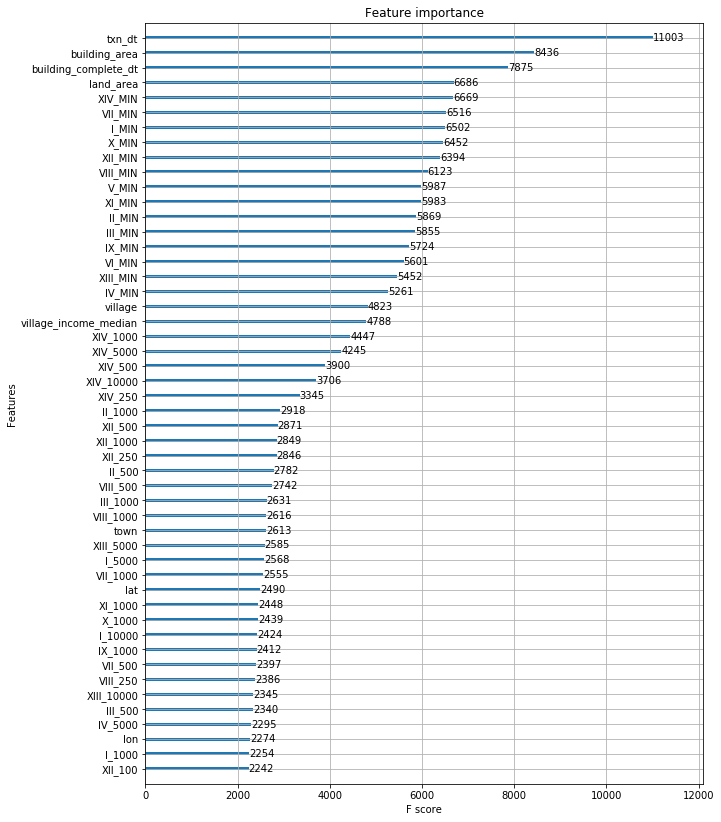

In [152]:
fig, ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(booster=model, ax=ax, max_num_features=50)

# submit the result

In [164]:
test_ = test.drop('building_id', axis=1)
pred = model.predict(test_)
pred_ = np.floor(np.expm1(pred))
test_id = test['building_id']
data = {'building_id':test_id, 'total_price':pred_}
sub = pd.DataFrame(data) 

In [165]:
sub.head()

,building_id,total_price
60000,X5gsdTWGS3W7JJQB,13124530.0
60001,BTshNOJyKHnT2YIT,3917242.0
60002,dhdymr0lV8N5kZOT,11085087.0
60003,VEwyGGMcD56w5BOc,6118444.0
60004,wmUeMoJZfsqaSX9b,1084071.0


In [166]:
sub.to_csv('sub_17.csv',index=False)